# How much money can we save by cutting public sector wages?

In [1]:
import pandas as pd
import numpy as np

from scipy.special import erfinv
from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('3399-dados.csv', sep=';')

### Filtering and cleaning the dataset

In [3]:
df = df[df['ano'] == 2019]

df = df[(df['origem'] == 'Público') | \
        (df['origem'] == 'Executivo') |\
        (df['origem'] == 'Legislativo') |\
        (df['origem'] == 'Judiciário') |\
        (df['origem'] == 'Federal') |\
        (df['origem'] == 'Estadual') |\
        (df['origem'] == 'Municipal')
       ]

df['part'] = df['part'].astype('category')
df['origem'] = df['origem'].astype('category')

df_2019 = df.drop(['ano'], axis=1)

df_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, 0 to 5262
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   origem  77 non-null     category
 1   part    77 non-null     category
 2   valor   77 non-null     float64 
dtypes: category(2), float64(1)
memory usage: 2.1 KB


In [4]:
#Organizing values for correct display on original data

replace_dict = {
    '1º Decil': '10th Dec',
    '2º Decil': '20th Dec',
    '3º Decil': '30th Dec',
    '4º Decil': '40th Dec',
    '6º Decil': '60th Dec',
    '7º Decil': '70th Dec',
    '8º Decil': '80th Dec',
    '9º Decil': '90th Dec',
    '1º Quartil': '25th Dec',
    '3º Quartil': '75th Dec',
    'Mediana': '50th Dec'
}

df_2019['part'] = df_2019['part'].replace(replace_dict)


order = sorted(df_2019['part'].unique())

### Generating Distributions

In [5]:
# Organizing a new DataFrame, to generate a distribution with 'fake' data.
# This will make some calculations easier down the road.


# Convert the 'part' column to a numerical representation of deciles
# For example, '10th Dec' becomes 0.1, '20th Dec' becomes 0.2, etc.
df_2019_faux = df_2019.copy()
df_2019_faux['decile'] = df_2019_faux['part'].str.extract('(\d+)').astype(int)/10



# Drop the original 'part' column as we now have 'decile'
df_2019_faux = df_2019_faux.drop(['part'], axis=1)

df_2019_faux = df_2019_faux.sort_values(by=['origem', 'decile'])

In [6]:
df_2019_faux.columns

Index(['origem', 'valor', 'decile'], dtype='object')

In [7]:
# Initialize an empty DataFrame to store the generated fake data
fake_data_df = pd.DataFrame(columns=['origem', 'fake_wage'])

sampleAmount = 500000

# Initialize a list to collect DataFrames
fake_data_dfs = []
dataEval = []
# Loop through each unique 'origem' to generate the fake data
for origem in df_2019_faux['origem'].unique():
    
    df_origem = df_2019_faux[df_2019_faux['origem'] == origem]    

    wages = df_origem['valor'].values
    
    # Reshape the data to fit the KDE model
    wages = wages.reshape(-1, 1)
    
    # Fit a Kernel Density model to the data
    kde = KernelDensity(kernel='gaussian', bandwidth=1200).fit(wages)
    
    # Sample from the fitted KDE model
    fake_wages = kde.sample(n_samples=sampleAmount, random_state=None)
    fake_wages = fake_wages.ravel()  # Flatten the array
    
    # Create a DataFrame, removes negative values, then append it to the list
    fake_data_origem = pd.DataFrame({'origem': [origem] * sampleAmount, 'fake_wage': fake_wages})
    fake_data_origem = fake_data_origem[fake_data_origem['fake_wage'] > min(wages)[0]]
    fake_data_dfs.append(fake_data_origem)
    
    dataEval.append(kde.score_samples(wages).mean())

print("Error Metric:", pd.DataFrame(dataEval).iloc[1].mean())

# Concatenate all the collected DataFrames at once
fake_data_df = pd.concat(fake_data_dfs, ignore_index=True)

Error Metric: -8.940403332545928


In [8]:
# Filter the fake data for 'Executivo'

fake_data_executivo = fake_data_df[fake_data_df['origem'] == 'Executivo']

In [9]:
comparison_df = pd.DataFrame()

percentList = [.1, .2, .25, .3, .4, .5, .6, .7, .75, .8, .9]

comparison_df['fake_data'] = fake_data_executivo.describe(percentiles = percentList)
comparison_df['real_data'] = df_2019[df_2019['origem'] == 'Executivo'].describe(percentiles = percentList)

comparison_df['difference'] = ((comparison_df['fake_data'] - comparison_df['real_data']) / comparison_df['real_data']) * 100

comparison_df['difference'] = comparison_df['difference'].round(2)

comparison_df.iloc[3:,2]

min     0.00
10%    15.06
20%    31.63
25%    37.61
30%    43.16
40%    37.65
50%    30.81
60%    22.83
70%    13.39
75%    15.14
80%    18.24
90%    30.38
max    57.54
Name: difference, dtype: float64

In [10]:
fake_data_executivo['fake_wage'].shape

(411215,)

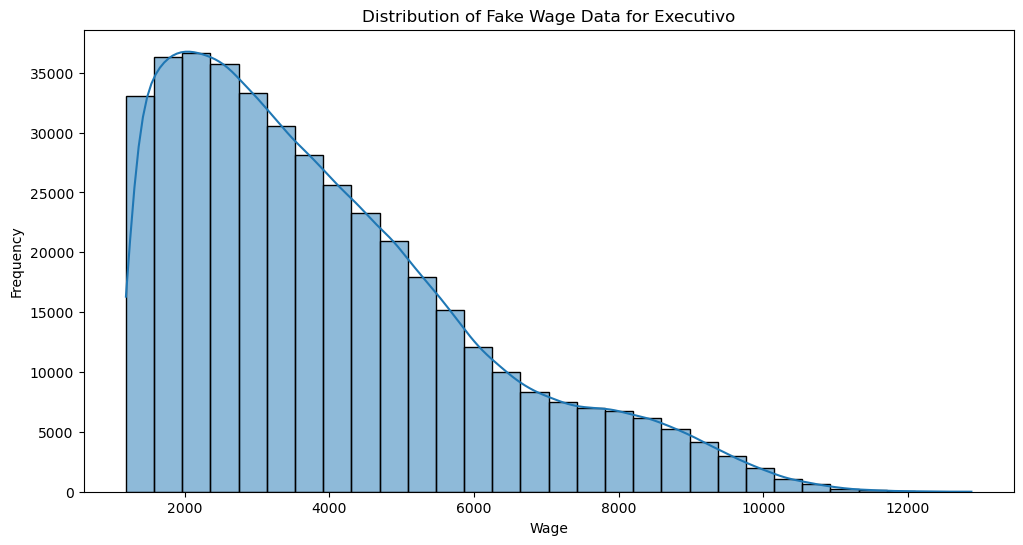

In [11]:
# Plot the distribution of the fake wage data for 'Executivo'

plt.figure(figsize=(12, 6))

sns.histplot(fake_data_executivo['fake_wage'], bins=30, kde=True)
plt.title('Distribution of Fake Wage Data for Executivo')
plt.xlabel('Wage')
plt.ylabel('Frequency')
plt.show()

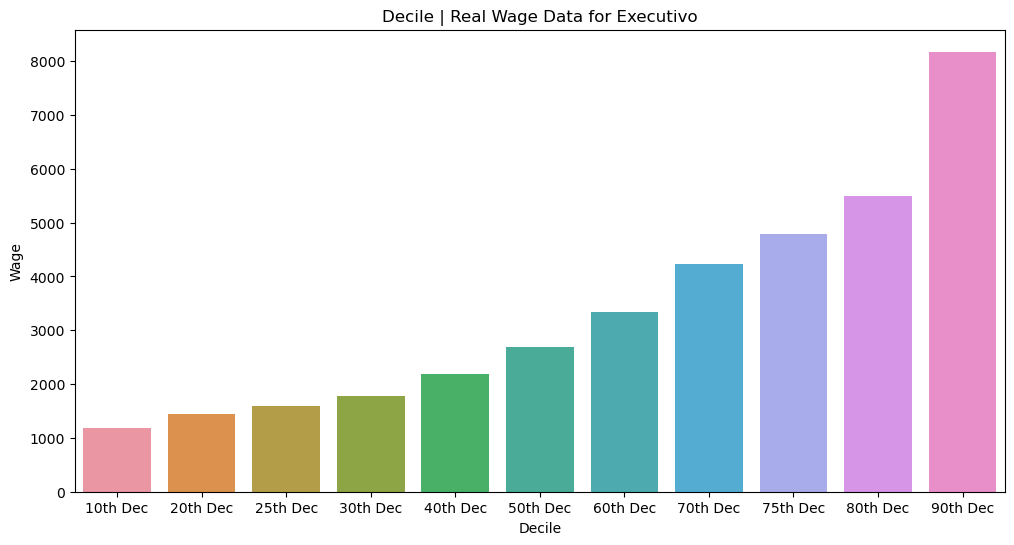

In [12]:
plt.figure(figsize=(12, 6))

sns.barplot(x='part', y='valor', data= df_2019[df_2019['origem'] == 'Executivo'], order = order)
plt.title('Decile | Real Wage Data for Executivo')
plt.xlabel('Decile')
plt.ylabel('Wage')
plt.show()

## Next steps:

- We need to add 'fat' to the amount of people we're generating in the faux-data, proportional to how many people we're removing (when they earn below the minimum salary).

- We need to test the distribution sum against real world data (~11 million people, get their wage budget)
    Then, we just need to scale faux-wage to match real-world wage (I wager it'll be under-estimated a bit. But we'll see).
    
- Document this notebook properly

In [13]:
###





















###